In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
from time import time

from sklearn import metrics
from sklearn import decomposition
from sklearn.cluster import (KMeans, AgglomerativeClustering)

SEED = 666

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
sns.set_style('white')

from audiovocana.dataset import get_dataset
from audiovocana.preprocessing import get_dataframe

PLOT = True
RESULTS_FOLDER = "/home/utilisateur/Desktop/palomars/ultra-sonic-vocalizations/experiments/full-dataset/results"

~~~~~~ AUDIOVOCANA SETTINGS ~~~~~~
AUDIOPARAMS 
 {'sr': 250000, 'mono': True}
STFTPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'win_length': 8192, 'center': True, 'window': 'hann'}
SPECTRALCENTROIDPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None}
SPECTRALBANDWIDTHPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'hop_length': 512, 'freq': None, 'centroid': None, 'norm': True, 'p': 2}
SPECTRALFLATNESSPARAMS 
 {'n_fft': 8192, 'hop_length': 512, 'amin': 1e-10, 'power': 2.0}
ZEROCRPARAMS 
 {'frame_length': 2048, 'hop_length': 512, 'center': True}
MELPARAMS 
 {'sr': 250000, 'n_fft': 8192, 'n_mels': 128, 'fmin': 0, 'fmax': 125000.0, 'htk': True}
MFCCPAMARS 
 {'sr': 250000, 'n_mfcc': 13, 'dct_type': 2, 'norm': 'ortho', 'htk': True}
mel fiterbank shape = (128, 4097)
Minimun waveform length accepted is 4104 PCM points.
Minimun audio duration accepted is 16.416 miliseconds.
STFT time resolution = 32.768 ms.
STFT frequency resolution = 30.5101293629485 Hz.


/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/utilisateur/anaconda3/envs/usv/lib/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
# full
csv_path = '/home/utilisateur/Desktop/palomars/data/full/dataset.csv'
cache_folder = '/home/utilisateur/Desktop/palomars/cache/full_dataset'
xlsx_folder = "/home/utilisateur/Desktop/palomars/data/full/xlsx_files"
audio_folder = "/media/utilisateur/LACIE SHARE/paloma-USV-data/audio"

In [4]:
df = get_dataframe(
    xlsx_folder=xlsx_folder,
    audio_folder=audio_folder,
    csv_path=csv_path,
    save=True
)

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings


In [5]:
print(f"Nb audibles = {len(df[df.vocalization == 1])}")
print(f"Nb USVs = {len(df[df.vocalization == 2])}")
print(f"Audible events represents the {len(df[df.vocalization == 1])/len(df)}% of total.")

Nb audibles = 2204
Nb USVs = 2013
Audible events represents the 0.522646431112165% of total.


In [6]:
dataset = get_dataset(
    csv_path=csv_path,
    cache_folder=cache_folder,
    shuffle=False,
    recompute=False
)

Reading csv from /home/utilisateur/Desktop/palomars/data/full/dataset.csv.
Found 4217 events from 46 different experiments and 132 different recordings


# 2019 recordings

In [7]:
dataset = dataset.filter(lambda sample: sample['year'] == 19)

In [8]:
y = np.array([sample['vocalization'].numpy() for sample in iter(dataset)])

In [9]:
print(f"Nb audibles = {np.sum(y == 1)}")
print(f"Nb USVs = {np.sum(y == 2)}")
print(f"Audible events represents the {100 * np.sum(y == 1)/len(y)}% of total.")

Nb audibles = 1005
Nb USVs = 436
Audible events represents the 69.74323386537127% of total.


In [10]:
def compute_clustering_metrics(y, y_pred):
    
    how_clustered = np.argmax([
    metrics.accuracy_score((y + 2) % 2, y_pred),
    metrics.accuracy_score((y-1), y_pred)])

    if how_clustered == 0:
        y_gt = (y + 2) % 2
    else:
        y_gt = y-1
    
    ari = metrics.adjusted_rand_score(y_gt, y_pred)
    ami = metrics.adjusted_mutual_info_score(y_gt, y_pred)
    acc = metrics.balanced_accuracy_score(y_gt, y_pred)
    
    clustering_metrics = {
        'feat': feat,
        'ARI': ari,
        'AMI': ami,
        'BACC': acc,
    }
    
    return y_gt, clustering_metrics

In [11]:
results = []

**Naive k-means**

## **Reduce features dimension to 2 with PCA and whitening, then apply k-means algorithme on the 2 dimensions that better explain data.**

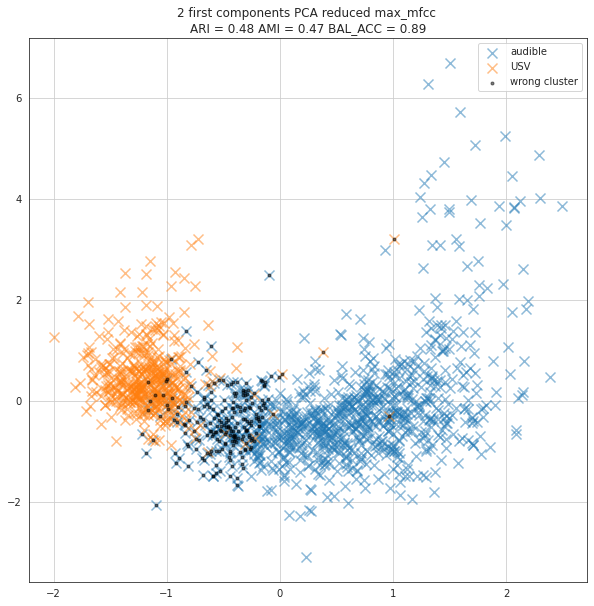

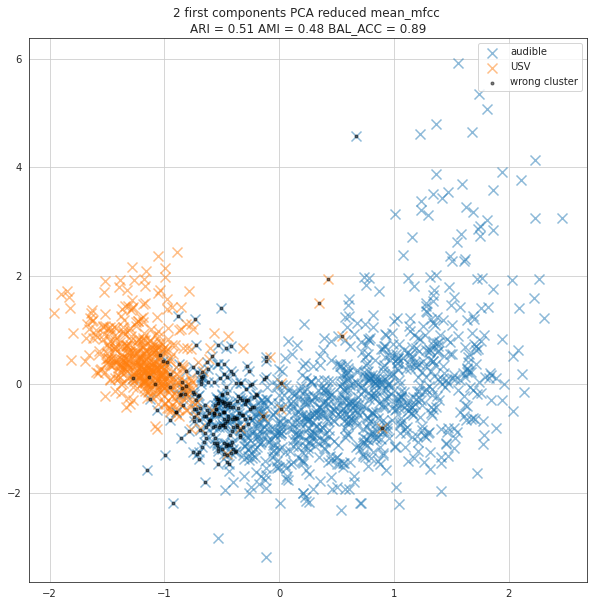

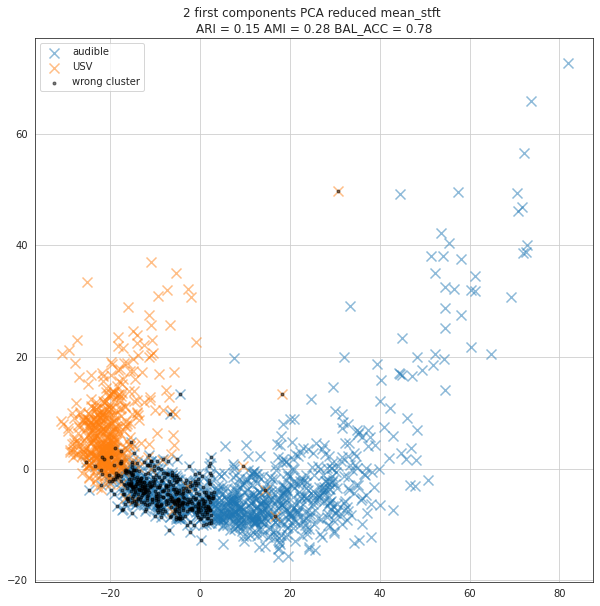

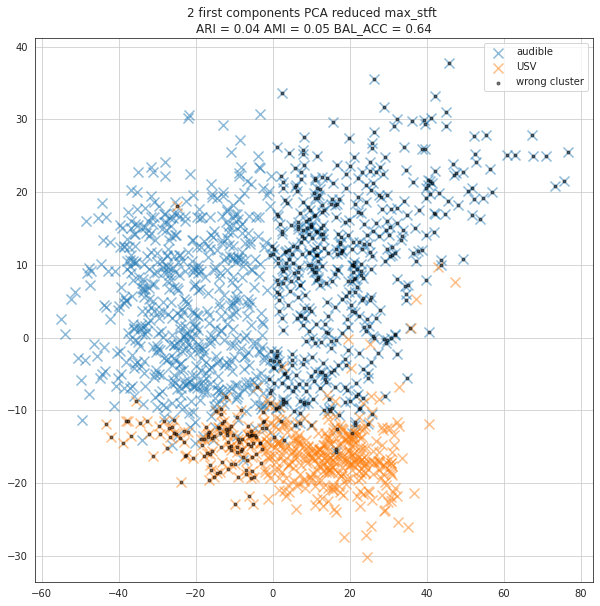

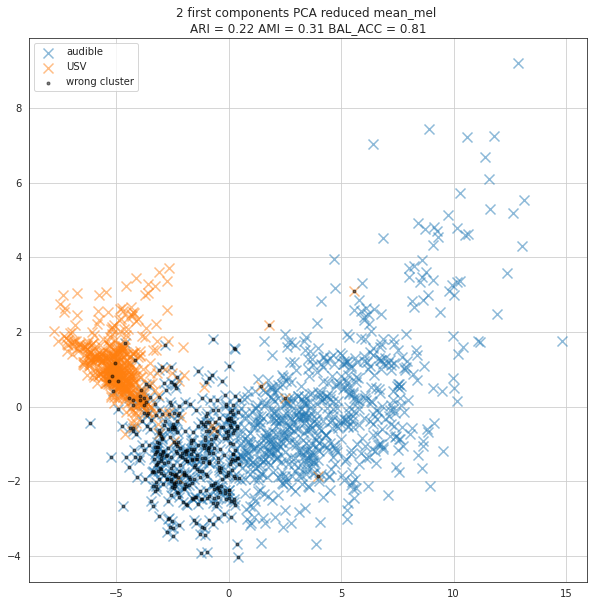

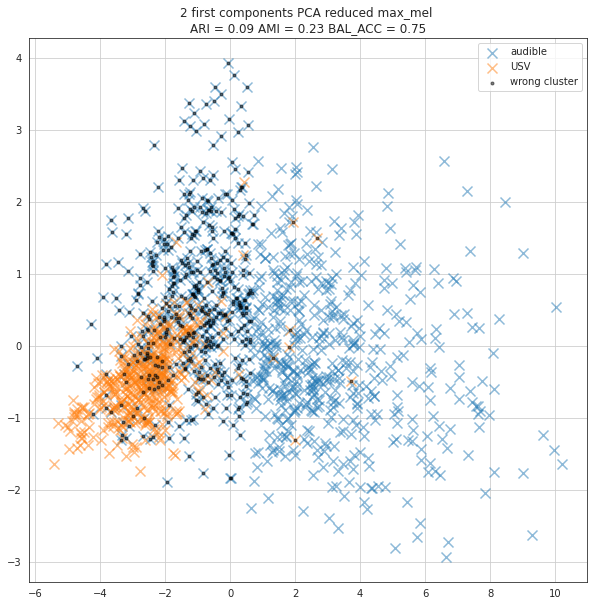

In [12]:
for feat in  ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']: 

    t0 = time()

    X = np.array([sample[feat] for sample in iter(dataset)]) 

    whiten = True if feat[-4:] == 'mfcc' else False
        
    pca = decomposition.PCA(whiten=whiten)
    pca.fit(X)
    #print(pca.explained_variance_) 
    pca.n_components = 2
    X_reduced = pca.fit_transform(X)

    y_clusters = KMeans(n_clusters=2, random_state=SEED).fit_predict(X_reduced)

    y_gt, mtcs = compute_clustering_metrics(y, y_clusters)

    mtcs['method'] = 'PCA+Kmeans'
    mtcs['time'] = time() - t0
    results.append(mtcs)
    
    if PLOT:
        X_wrong_cluster = X_reduced[y_gt != y_clusters]

        title = f"2 first components PCA reduced {feat} \n" \
            + f"ARI = {'{:.2f}'.format(mtcs['ARI'])} " \
            + f"AMI = {'{:.2f}'.format(mtcs['AMI'])} " \
            + f"BAL_ACC = {'{:.2f}'.format(mtcs['BACC'])}"

        fig, ax = plt.subplots(figsize=(10, 10))

        ax.scatter(X_reduced[y == 1][:, 0], X_reduced[y == 1][:, 1],
                   c='tab:blue', s=100, marker='x', label='audible', alpha=0.5)

        ax.scatter(X_reduced[y == 2][:, 0], X_reduced[y == 2][:, 1],
                   c='tab:orange', s=100, marker='x', label='USV', alpha=0.5)

        ax.scatter(X_wrong_cluster[:, 0], X_wrong_cluster[:, 1],
                   c='black', marker='.', label='wrong cluster', alpha=0.5)

        ax.legend()
        ax.grid(True)
        plt.title(title)
        plt.show()

## **Apply hierarchical clustering algorithme with 2 clusters.**

In [13]:
for feat in  ['max_mfcc', 'mean_mfcc', 'mean_stft', 'max_stft', 'mean_mel', 'max_mel']: 

    X = np.array([sample[feat] for sample in iter(dataset)]) 
        
    clustering = AgglomerativeClustering(
        n_clusters=2,
        affinity='euclidean',
        memory=None,
        connectivity=None,
        compute_full_tree='auto',
        linkage='ward',
        distance_threshold=None).fit(X)

    y_clusters = clustering.labels_

    y_gt, mtcs = compute_clustering_metrics(y, y_clusters)

    mtcs['method'] = 'AgglomerativeClustering'
    results.append(mtcs)
    

## **Metrics**

In [14]:
df = pd.DataFrame.from_records(results).sort_values(by='ARI', ascending=False).rename({
    'feat': 'Audio Feature',
    'BACC': 'Balanced Accuracy',
    'ARI': 'Adjusted Rand Index',
    'AMI': 'Adjusted Mutual Inforation',
    'time': 'TIME_s'
}, axis=1)

In [15]:
df

,Audio Feature,Adjusted Rand Index,Adjusted Mutual Inforation,Balanced Accuracy,method,TIME_s
6,max_mfcc,0.908234,0.825227,0.973194,AgglomerativeClustering,NaN
1,mean_mfcc,0.508374,0.481929,0.892968,PCA+Kmeans,5.514726
0,max_mfcc,0.483294,0.472626,0.887798,PCA+Kmeans,5.913144
8,mean_stft,0.218392,0.319766,0.807353,AgglomerativeClustering,NaN
4,mean_mel,0.215784,0.314344,0.805709,PCA+Kmeans,20.377560
2,mean_stft,0.147984,0.275607,0.778843,PCA+Kmeans,391.212176
7,mean_mfcc,0.105621,0.254712,0.760587,AgglomerativeClustering,NaN
5,max_mel,0.090847,0.234500,0.751176,PCA+Kmeans,20.420827
11,max_mel,0.057988,0.210567,0.733114,AgglomerativeClustering,NaN
3,max_stft,0.040969,0.052959,0.640756,PCA+Kmeans,416.698403


In [16]:
#df.to_csv(os.path.join(RESULTS_FOLDER, "metrics.csv"), index=False)